<a href="https://colab.research.google.com/github/peisuke/homography-estimation/blob/main/homography_ex6_DHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mazenmel/Deep-homography-estimation-Pytorch.git

Cloning into 'Deep-homography-estimation-Pytorch'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 295.85 KiB | 11.38 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
import glob
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import cv2

In [3]:
!wget https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip

--2022-04-22 05:12:09--  https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1508977 (1.4M) [application/zip]
Saving to: ‘pair_images.zip’

pair_images.zip     100%[===================>]   1.44M  --.-KB/s    in 0.04s   

2022-04-22 05:12:10 (40.1 MB/s) - ‘pair_images.zip’ saved [1508977/1508977]



In [4]:
!cp /content/drive/MyDrive/colab_data/pair_images.zip .
!unzip -q pair_images.zip

cp: cannot stat '/content/drive/MyDrive/colab_data/pair_images.zip': No such file or directory


In [5]:
!gdown --id 1w0qPdYSPTAO4A136SzabfBaMl48u8lHH

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1w0qPdYSPTAO4A136SzabfBaMl48u8lHH
To: /content/DeepHomographyEstimation2.pth
100% 274M/274M [00:02<00:00, 104MB/s]


In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(2,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
                                    
        self.layer2 = nn.Sequential(nn.Conv2d(64,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(64,64,3,padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer5 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())        
        self.layer6 = nn.Sequential(nn.Conv2d(128,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer7 = nn.Sequential(nn.Conv2d(128,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(128,128,3,padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.fc1 = nn.Linear(128*16*16,1024)
        self.fc2 = nn.Linear(1024,8)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(-1,128* 16* 16)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
model = Model()

state_dict = torch.load('./DeepHomographyEstimation2.pth', map_location='cpu')['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
def compute_four_points(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    images = np.stack((img1_gray, img2_gray), 2)

    x = torch.from_numpy((images.astype(float)-127.5)/127.5)
    x = x.unsqueeze(0)
    x = x.permute(0,3,1,2).float()

    model.eval()
    with torch.no_grad():
        outputs = model(x)

    H_four_points_pred = (outputs[0] * 32).numpy().reshape((4, 2)).astype(int)

    return H_four_points_pred

In [9]:
def transform(img2, img1, H_four_points_pred):
    fp = np.array([[32, 32], [160, 32], [160, 160], [32, 160]])

    perturbed_four_points = H_four_points_pred + fp
    H = cv2.getPerspectiveTransform( np.float32(fp), np.float32(perturbed_four_points) )

    tmp2 = np.pad(img2, ((32, 32), (32, 32), (0, 0)))
    warped_image2 = cv2.warpPerspective(tmp2, H, (192,192))
    warped_image2 = warped_image2[32:160, 32:160]

    return warped_image2

In [10]:
fp = np.array([[0, 0], [128, 0], [128, 128], [0, 128]])

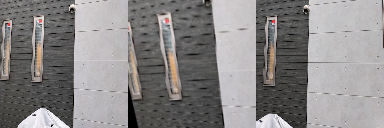

In [11]:
files = sorted(glob.glob('pair_images/pair_01/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

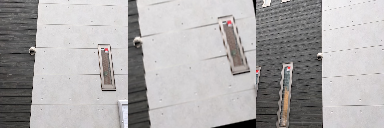

In [12]:
files = sorted(glob.glob('pair_images/pair_02/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

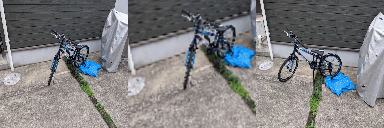

In [13]:
files = sorted(glob.glob('pair_images/pair_03/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

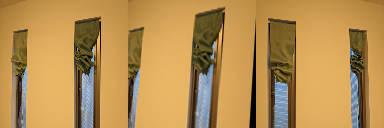

In [14]:
files = sorted(glob.glob('pair_images/pair_04/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

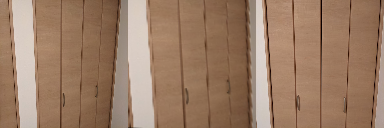

In [15]:
files = sorted(glob.glob('pair_images/pair_05/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

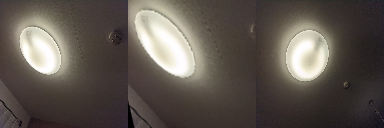

In [16]:
files = sorted(glob.glob('pair_images/pair_06/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

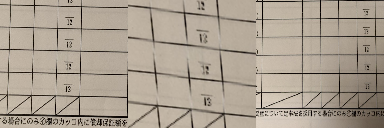

In [17]:
files = sorted(glob.glob('pair_images/pair_07/*.jpg'))

img1 = cv2.resize(cv2.imread(files[0]), (128, 128))
img2 = cv2.resize(cv2.imread(files[1]), (128, 128))

H_four_points_pred = compute_four_points(img2, img1)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))

### サンプルデータでのテスト

In [18]:
!wget https://raw.githubusercontent.com/peisuke/homography-estimation/main/dhe_data.zip

--2022-04-22 05:12:17--  https://raw.githubusercontent.com/peisuke/homography-estimation/main/dhe_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15156 (15K) [application/zip]
Saving to: ‘dhe_data.zip’

dhe_data.zip        100%[===================>]  14.80K  --.-KB/s    in 0s      

2022-04-22 05:12:17 (99.2 MB/s) - ‘dhe_data.zip’ saved [15156/15156]



In [19]:
!unzip dhe_data.zip

Archive:  dhe_data.zip
  inflating: img_patch_1.jpg         
  inflating: __MACOSX/._img_patch_1.jpg  
  inflating: img_patch_2.jpg         
  inflating: __MACOSX/._img_patch_2.jpg  


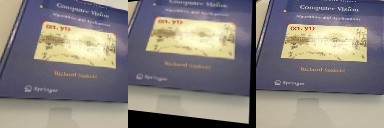

In [20]:
img1 = cv2.resize(cv2.imread('img_patch_1.jpg'), (128, 128))
img2 = cv2.resize(cv2.imread('img_patch_2.jpg'), (128, 128))

H_four_points_pred = compute_four_points(img1, img2)

warped_image2 = transform(img2, img1, H_four_points_pred)
display(Image.fromarray(cv2.cvtColor(np.concatenate((img2, warped_image2, img1), axis=1), cv2.COLOR_BGR2RGB)))